In [1]:
import os
import gc
import PIL
import cv2
import uuid
import shutil
import glob as gb
import numpy as np
import pandas as pd
from tqdm import tqdm  # Progress bar
import matplotlib.pyplot as plt
%matplotlib inline


import keras
from sklearn.utils import shuffle
from keras.optimizers import Adam
from keras.regularizers import l1_l2
from keras.utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, Input
from keras.layers import GlobalAveragePooling2D
from keras.callbacks import LearningRateScheduler
from keras.layers import Conv2D, MaxPool2D, BatchNormalization
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import random

from sklearn.model_selection import train_test_split

random.seed(100)

In [2]:
dicom_df = pd.read_csv("C:/Users/AIMVLab/Desktop/flodo/CNN_Breast Cancer/CBIS-DDSM/csv/dicom_info.csv")

In [3]:
cropped_images = dicom_df[dicom_df.SeriesDescription=="cropped images"].image_path
cropped_images.head()

0     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308...
3     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.381187...
6     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
7     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
10    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
Name: image_path, dtype: object

In [4]:
full_mammogram = dicom_df[dicom_df.SeriesDescription=="full mammogram images"].image_path
full_mammogram.head()

1     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386...
2     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.267213...
11    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.210396...
12    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.749566...
15    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.987658...
Name: image_path, dtype: object

In [5]:
roi_mask = dicom_df[dicom_df.SeriesDescription=="ROI mask images"].image_path
roi_mask.head()

5     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339...
8     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.178994...
9     CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.411833...
14    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.236373...
20    CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.357008...
Name: image_path, dtype: object

In [6]:
def replace_path(sample, old_path, new_path):
    return sample.replace(old_path, new_path, regex=True)

In [7]:
def plot_smaples(sample, row=15, col=15):
    plt.figure(figsize=(row, col))
    for i, file in enumerate(sample[0:5]):
        cropped_images_show = PIL.Image.open(file)
        gray_img= cropped_images_show.convert("L")
        plt.subplot(1,5,i+1)
        plt.imshow(gray_img, cmap='gray')
        plt.axis('off')
    plt.show()

In [8]:
correct_dir = "C:/Users/AIMVLab/Desktop/flodo/CNN_Breast Cancer/CBIS-DDSM/jpeg"

In [9]:
cropped_images = replace_path(cropped_images, "CBIS-DDSM/jpeg", correct_dir)
print('Cropped Images paths:')
print(cropped_images.iloc[0])

Cropped Images paths:
C:/Users/AIMVLab/Desktop/flodo/CNN_Breast Cancer/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304/1-172.jpg


In [10]:
full_mammogram = replace_path(full_mammogram, "CBIS-DDSM/jpeg", correct_dir)
print('\nFull mammo Images paths:')
print(full_mammogram.iloc[0])


Full mammo Images paths:
C:/Users/AIMVLab/Desktop/flodo/CNN_Breast Cancer/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.248386742010678582309005372213277814849/1-249.jpg


In [11]:
roi_mask = replace_path(roi_mask, "CBIS-DDSM/jpeg", correct_dir)
print('\nROI Mask Images paths:')
print(roi_mask.iloc[0])


ROI Mask Images paths:
C:/Users/AIMVLab/Desktop/flodo/CNN_Breast Cancer/CBIS-DDSM/jpeg/1.3.6.1.4.1.9590.100.1.2.153339052913121382622526066491844156138/2-270.jpg


In [12]:
def get_image_file_name(data, new_dict):
    """
    /kaggle
    /input
    /cbis-ddsm-breast-cancer-image-dataset
    /jpeg
    /1.3.6.1.4.1.9590.100.1.2.129308726812851964007517874181459556304 [5]
    /1-172.jpg
    
    return path at index [9] after split depends on split('\')
    """
    for dicom in data:
        key = dicom.split('/')[8]
#         print(key)
        new_dict[key] = dicom
    print(f"the length of dataset ==> {len(new_dict.keys())}")

In [13]:
cropped_images_dict = dict()
full_mammo_dict = dict()
roi_img_dict = dict()

get_image_file_name(cropped_images, cropped_images_dict)
get_image_file_name(full_mammogram, full_mammo_dict)
get_image_file_name(roi_mask, roi_img_dict)

the length of dataset ==> 3567
the length of dataset ==> 2857
the length of dataset ==> 3247


In [14]:
def fix_image_path(data):
    """Correct dicom paths to correct image paths."""
    for indx, image in enumerate(data.values):
#         print(f"Image Path: {image[11]}")

        img_name = image[11].split('/')[2]
#         print(f"Looking for key: {img_name}")  # Debugging step

        if img_name in full_mammo_dict:
            data.iloc[indx, 11] = full_mammo_dict[img_name]
        else:
            data.iloc[indx, 11] = None
#             print(f"KeyError: '{img_name}' not found in full_mammo_dict")  # Debugging step
        
        img_name = image[12].split('/')[2]
        if img_name in cropped_images_dict:
            data.iloc[indx, 12] = cropped_images_dict[img_name]
        else:
            data.iloc[indx, 12] = None
#             print(f"KeyError: '{img_name}' not found in cropped_images_dict")  # Debugging step

In [15]:
mass_train = pd.read_csv("C:/Users/AIMVLab/Desktop/flodo/CNN_Breast Cancer/CBIS-DDSM/csv/mass_case_description_train_set.csv")
mass_test  = pd.read_csv("C:/Users/AIMVLab/Desktop/flodo/CNN_Breast Cancer/CBIS-DDSM/csv/mass_case_description_test_set.csv")

In [16]:
fix_image_path(mass_train)

In [17]:
mass_train = mass_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})


In [18]:
fix_image_path(mass_test)

In [19]:
mass_test = mass_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                      'image view': 'image_view',
                                      'abnormality id': 'abnormality_id',
                                      'abnormality type': 'abnormality_type',
                                      'mass shape': 'mass_shape',
                                      'mass margins': 'mass_margins',
                                      'image file path': 'image_file_path',
                                      'cropped image file path': 'cropped_image_file_path',
                                      'ROI mask file path': 'ROI_mask_file_path'})



In [20]:
print(f'Shape of mass_train: {mass_train.shape}')
print(f'Shape of mass_test: {mass_test.shape}')

Shape of mass_train: (1318, 14)
Shape of mass_test: (378, 14)


In [21]:
calc_train = pd.read_csv("C:/Users/AIMVLab/Desktop/flodo/CNN_Breast Cancer/CBIS-DDSM/csv/calc_case_description_train_set.csv")
calc_test  = pd.read_csv("C:/Users/AIMVLab/Desktop/flodo/CNN_Breast Cancer/CBIS-DDSM/csv/calc_case_description_test_set.csv")

In [22]:
calc_train = calc_train.rename(columns={'left or right breast': 'left_or_right_breast',
                                        'image view': 'image_view',
                                        'abnormality id': 'abnormality_id',
                                        'abnormality type': 'abnormality_type',
                                        'mass shape': 'mass_shape',
                                        'mass margins': 'mass_margins',
                                        'image file path': 'image_file_path',
                                        'cropped image file path': 'cropped_image_file_path',
                                        'ROI mask file path': 'ROI_mask_file_path'})

In [23]:
fix_image_path(calc_train)

In [24]:
calc_test = calc_test.rename(columns={'left or right breast': 'left_or_right_breast',
                                      'image view': 'image_view',
                                      'abnormality id': 'abnormality_id',
                                      'abnormality type': 'abnormality_type',
                                      'mass shape': 'mass_shape',
                                      'mass margins': 'mass_margins',
                                      'image file path': 'image_file_path',
                                      'cropped image file path': 'cropped_image_file_path',
                                      'ROI mask file path': 'ROI_mask_file_path'})

In [25]:
fix_image_path(calc_test)

In [26]:
print(f'Shape of mass_train: {calc_train.shape}')
print(f'Shape of mass_test: {calc_test.shape}')

Shape of mass_train: (1546, 14)
Shape of mass_test: (326, 14)


In [27]:
full_dataset = pd.concat([mass_train, mass_test, calc_train, calc_test], axis=0)

In [28]:
class_mapper = {'MALIGNANT': 1, 'BENIGN': 0, 'BENIGN_WITHOUT_CALLBACK': 0} 

In [29]:
target_size = (112, 112, 3) #112

In [30]:
# Apply class mapper to pathology column
full_dataset['labels'] = full_dataset['pathology'].replace(class_mapper).infer_objects(copy=False)

full_images = np.array(full_dataset[full_dataset["image_file_path"].notna()]["image_file_path"].tolist())
full_labels = np.array(full_dataset[full_dataset["image_file_path"].notna()]["labels"].tolist())

C:\Users\AIMVLab\AppData\Local\Temp\ipykernel_45168\614134976.py:2: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  full_dataset['labels'] = full_dataset['pathology'].replace(class_mapper).infer_objects(copy=False)


In [31]:
num_classes = len(full_dataset['labels'].unique())
num_classes

2

In [32]:
class_names = ['Benign', 'Malignant']

In [33]:
# Check the distribution of labels
label_counts = full_dataset['labels'].value_counts()
print(label_counts)

labels
0    2111
1    1457
Name: count, dtype: int64


In [34]:
def copy_images_with_unique_filenames(source_images, source_labels, destination_dir):
    """
    Copy images from source to destination_dir in subfolders '0' and '1', ensuring unique filenames.
    """
    benign_images = 0
    malignant_images = 0
    skipped_images = []

    # Create the destination subfolders '0' and '1'
    category_dest_dir_zero = os.path.join(destination_dir, '0')
    os.makedirs(category_dest_dir_zero, exist_ok=True)
    
    category_dest_dir_one = os.path.join(destination_dir, '1')
    os.makedirs(category_dest_dir_one, exist_ok=True)

    # Copy all images to the appropriate folder based on the label
    for idx, (source, label) in enumerate(zip(source_images, source_labels)):
        if os.path.exists(source):
            try:
                # Generate a unique filename
                filename = os.path.basename(source)
                unique_filename = f"{uuid.uuid4().hex}_{filename}"
                
                if label == 0:
                    shutil.copy(source, os.path.join(category_dest_dir_zero, unique_filename))
                    benign_images += 1
                elif label == 1:
                    shutil.copy(source, os.path.join(category_dest_dir_one, unique_filename))
                    malignant_images += 1
                
#                 print(f"Copied image {idx + 1}/{len(source_images)} to class {label}")
            except Exception as e:
                print(f"Error copying image {source}: {e}")
                skipped_images.append(source)
        else:
            print(f"Image not found: {source}")
            skipped_images.append(source)

    # After running the function
    print(f"\nCopying complete.")
    print(f"Benign images copied (label 0): {benign_images}")
    print(f"Malignant images copied (label 1): {malignant_images}")
    print(f"Total skipped images: {len(skipped_images)}")
    if skipped_images:
        print("Skipped images:")
        for img in skipped_images:
            print(img)

In [35]:
destination_dir = "D:/OKPALA/CNN_Breast Cancer/CBIS-DDSM/marged_images"  # Update this path as needed

copy_images_with_unique_filenames(full_images, full_labels, destination_dir)


Copying complete.
Benign images copied (label 0): 1931
Malignant images copied (label 1): 1355
Total skipped images: 0


In [36]:
def copy_images_to_destination(source_dir, destination_dir):
    """
    Move or copy images from source_dir to destination_dir in subfolders '0' and '1'.
    """
    # Define the categories (class labels) as '0' and '1'
    categories = ['0', '1']
    
    for category in categories:
        # Create the destination subfolder (e.g., '0' or '1') if it doesn't exist
        category_dest_dir = os.path.join(destination_dir, category)
        os.makedirs(category_dest_dir, exist_ok=True)
        
        # Path to the current category folder in the source directory
        category_source_dir = os.path.join(source_dir, category)
        
        # Move or copy all images from the source category folder to the destination folder
        for img_name in os.listdir(category_source_dir):
            # Construct full file paths
            img_source_path = os.path.join(category_source_dir, img_name)
            img_dest_path = os.path.join(category_dest_dir, img_name)
            
            # Copy the image to the destination folder (you can use shutil.move to move instead of copy)
            shutil.copy(img_source_path, img_dest_path)
            
            # Optionally, print the status
#             print(f"Copied {img_source_path} to {img_dest_path}")


In [37]:
# Define the paths to your dataset folders
test = "D:/ASMA/CNN_Breast Cancer/CBIS-DDSM/archive/test"
train = "D:/ASMA/CNN_Breast Cancer/CBIS-DDSM/archive/train"
valid = "D:/ASMA/CNN_Breast Cancer/CBIS-DDSM/archive/valid"

# Destination directory for the unified dataset
destination_dir = "D:/FLODO/marged_images"  # Update this path as needed

In [38]:
# Apply the function to each of the dataset folders (test, train, valid)
copy_images_to_destination(test, destination_dir)
copy_images_to_destination(train, destination_dir)
copy_images_to_destination(valid, destination_dir)

In [39]:
def image_processor(image_path, target_size):
    """Preprocess images for CNN model"""
    if image_path:
#         absolute_image_path = os.path.abspath(image_path)
        image = cv2.imread(image_path)
        
        # Check if the image was loaded successfully
        if image is None:
#             print(f"Warning: Failed to load image at {absolute_image_path}. Skipping this file.")
            return None

        # Resize the image and normalize it
        image = cv2.resize(image, (target_size[0], target_size[1]))
        image_array = image / 255.0  # Normalize the image to range [0, 1]
        return image_array
    else:
        return None

In [40]:
# path_zero = 'D:/ASMA/CNN_Breast Cancer/CBIS-DDSM/marged_images/0'
# path_one  = 'D:/ASMA/CNN_Breast Cancer/CBIS-DDSM/marged_images/1'

# # Preprocess and collect images and labels
# benign_images = np.array([image_processor(os.path.join(path_zero, x), (224, 224)) for x in os.listdir(path_zero)])
# benign_labels = np.array([0] * len(benign_images))  # Label 0 for benign

# malignant_images = np.array([image_processor(os.path.join(path_one, x), (224, 224)) for x in os.listdir(path_one)])
# malignant_labels = np.array([1] * len(malignant_images))  # Label 1 for malignant

In [41]:
import os
import cv2
import numpy as np
from concurrent.futures import ThreadPoolExecutor

def image_processor(image_path, target_size):
    """Preprocess images for CNN model."""
    image = cv2.imread(image_path)
    
    # Check if the image was loaded successfully
    if image is None:
        return None
    
    # Resize and normalize the image
    image = cv2.resize(image, target_size)
    return image

def load_images_from_directory(directory, target_size, label):
    """Load and preprocess images from a directory."""
    image_files = [entry.path for entry in os.scandir(directory) if entry.is_file()]
    
    with ThreadPoolExecutor() as executor:
        images = list(executor.map(lambda img: image_processor(img, target_size), image_files))
    
    # Filter out None values in case some images failed to load
    images = np.array([img for img in images if img is not None])
    labels = np.full(len(images), label)
    
    return images, labels

# Define paths and target size
path_zero = 'D:/ASMA/CNN_Breast Cancer/CBIS-DDSM/marged_images/0'
path_one  = 'D:/ASMA/CNN_Breast Cancer/CBIS-DDSM/marged_images/1'
target_size = (112, 112)

# Load benign and malignant images
benign_images, benign_labels = load_images_from_directory(path_zero, target_size, label=0)
malignant_images, malignant_labels = load_images_from_directory(path_one, target_size, label=1)


In [42]:
print(f"The Count of 0 is: {benign_images.shape}")
print()
print(f"The count of 0 label is: {benign_labels.shape}")
print()
print(f"The count of 1 is: {malignant_images.shape}")
print()
print(f"The count of 1 label is: {malignant_labels.shape}")

The Count of 0 is: (31190, 112, 112, 3)

The count of 0 label is: (31190,)

The count of 1 is: (21483, 112, 112, 3)

The count of 1 label is: (21483,)


In [43]:
# Concatenate images and labels
full_images = np.concatenate([benign_images, malignant_images])
full_labels = np.concatenate([benign_labels, malignant_labels])
print("Preprocessing complete. Images and labels combined.")

Preprocessing complete. Images and labels combined.


In [44]:
# Shuffle the dataset (images and labels in unison)
full_images, full_labels = shuffle(full_images, full_labels, random_state=42)

In [45]:
train_images, valid_images, train_labels, valid_labels = train_test_split(full_images, full_labels,test_size=0.2,random_state=40)
valid_images, test_images, valid_labels, test_labels = train_test_split(valid_images, valid_labels,test_size=0.5,random_state=40)

In [46]:
print("Train:")
print(train_images.shape)
print(train_labels.shape)
print("Valid:")
print(valid_images.shape)
print(valid_labels.shape)
print("Test:")
print(test_images.shape)
print(test_labels.shape)

Train:
(42138, 112, 112, 3)
(42138,)
Valid:
(5267, 112, 112, 3)
(5267,)
Test:
(5268, 112, 112, 3)
(5268,)


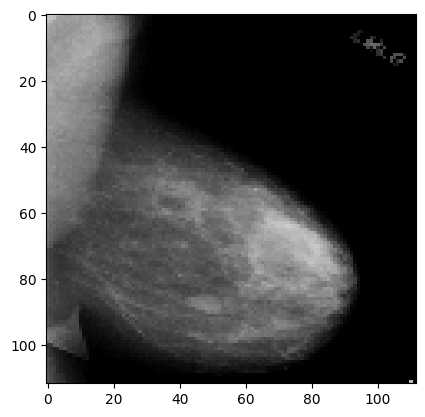

In [47]:
plt.imshow(train_images[10])
plt.show()

In [48]:
num_classes = 2

train_labels = to_categorical(train_labels, num_classes)
test_labels  = to_categorical(test_labels, num_classes)
valid_labels = to_categorical(valid_labels, num_classes)

In [49]:
import tensorflow as tf
#Model Archiecture
# num_classes = y_train.shape[1] * y_train.shape[2]
#input layer
inputs = tf.keras.Input(shape=(train_images.shape[1], train_images.shape[2], train_images.shape[3]))
x = inputs

# Convolutional Block
for filters in [32, 64, 128, 128]: 
    x = tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same", activation="relu",)(x)
    x = tf.keras.layers.Conv2D(filters, kernel_size=3, padding="same", activation="relu",)(x)
    x = tf.keras.layers.BatchNormalization()(x)
    x = tf.keras.layers.MaxPooling2D(pool_size=(2,2))(x)
    x = tf.keras.layers.Dropout(0.2)(x)
    
#fully Connected layer
x = tf.keras.layers.Flatten()(x)
# x = tf.keras.layers.GlobalMaxPooling1D()(x)
# x = tf.keras.layers.Dense(128, activation="relu", kernel_regularizer=l2(0.03))(x)
# x = tf.keras.layers.Dropout(0.5)(x)
x = tf.keras.layers.Dense(128, activation="relu")(x)
x = tf.keras.layers.Dropout(0.5)(x)

#output layer
outputs = tf.keras.layers.Dense(2, activation="softmax")(x)

model = tf.keras.models.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 112, 112, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 112, 112, 32)      896       
                                                                 
 conv2d_1 (Conv2D)           (None, 112, 112, 32)      9248      
                                                                 
 batch_normalization (BatchN  (None, 112, 112, 32)     128       
 ormalization)                                                   
                                                                 
 max_pooling2d (MaxPooling2D  (None, 56, 56, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 56, 56, 32)        0     

In [50]:
import datetime
# Compile the model
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001), loss=tf.losses.BinaryCrossentropy(), metrics=["accuracy","top_k_categorical_accuracy"])

model_folder ="D:\\ASMA\\trained_model"
# csv_path = os.path.join("files", "log.csv")
timestamp = datetime.datetime.now().strftime("%Y%m%d-%H%M%S")

# Define the callbacks
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(f'{model_folder}/Breast_cancer_model_{timestamp}.keras', monitor="val_loss", verbose=1, save_best_only=True),
    tf.keras.callbacks.ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=5, min_lr=1e-7),
    # tf.keras.callbacks.CSVLogger(csv_path),
    tf.keras.callbacks.EarlyStopping(monitor="val_loss", patience=10, restore_best_weights=False)
]

# # Define the number of validation steps
# steps_per_epoch = len(image_paths_train) // BATCH_SIZE
# validation_steps = len(image_paths_val) // BATCH_SIZE


In [51]:
import time

# Start the timer
start_time = time.time()

# Training the model
history = model.fit( 
    train_images, 
    train_labels,
    # steps_per_epoch=steps_per_epoch,
    epochs=1000,
    validation_data=(valid_images, valid_labels),
    # validation_steps=validation_steps,
    callbacks=callbacks,
    # class_weight = class_weights
)

# Stop the timer after training completes
end_time = time.time()

# Calculate the total training time
training_time = end_time - start_time

# Print the total training time in a human-readable format (hours, minutes, seconds)
hours, rem = divmod(training_time, 3600)
minutes, seconds = divmod(rem, 60)
print(f"Training Time: {int(hours)} hours, {int(minutes)} minutes, and {int(seconds)} seconds.")

print("This is the End!!!")


Epoch 1/1000
1317/1317 [==============================] - ETA: 0s - loss: 0.6325 - accuracy: 0.6279 - top_k_categorical_accuracy: 1.0000
Epoch 1: val_loss improved from inf to 0.89826, saving model to D:\ASMA\trained_model\Breast_cancer_model_20241018-140431.keras
1317/1317 [==============================] - 33s 19ms/step - loss: 0.6325 - accuracy: 0.6279 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.8983 - val_accuracy: 0.6385 - val_top_k_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 2/1000
1315/1317 [============================>.] - ETA: 0s - loss: 0.5395 - accuracy: 0.6973 - top_k_categorical_accuracy: 1.0000
Epoch 2: val_loss improved from 0.89826 to 0.78929, saving model to D:\ASMA\trained_model\Breast_cancer_model_20241018-140431.keras
1317/1317 [==============================] - 24s 18ms/step - loss: 0.5393 - accuracy: 0.6975 - top_k_categorical_accuracy: 1.0000 - val_loss: 0.7893 - val_accuracy: 0.6717 - val_top_k_categorical_accuracy: 1.0000 - lr: 1.0000e-04
Epoch 

In [52]:
model.evaluate(test_images, test_labels)

165/165 [==============================] - 1s 6ms/step - loss: 0.0559 - accuracy: 0.9641 - top_k_categorical_accuracy: 1.0000


[0.055902641266584396, 0.964123010635376, 1.0]

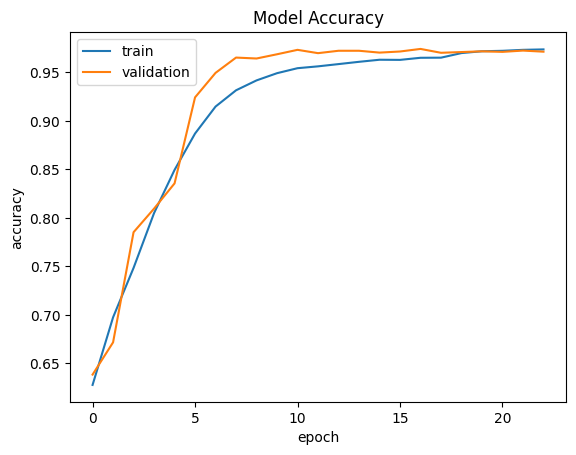

In [53]:
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model Accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

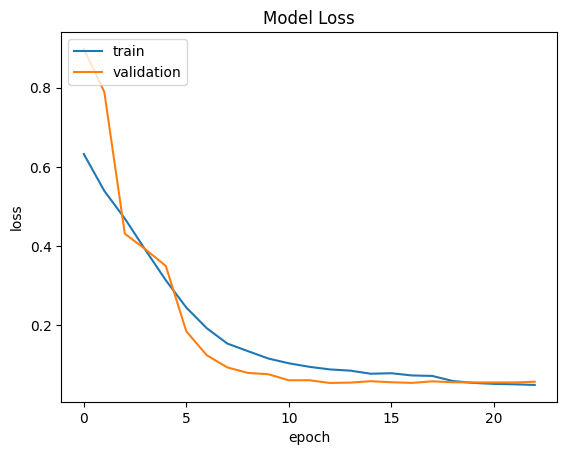

In [54]:
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model Loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'validation'], loc='upper left')
plt.show()

5268/5268 [==============================] - 14s 3ms/step


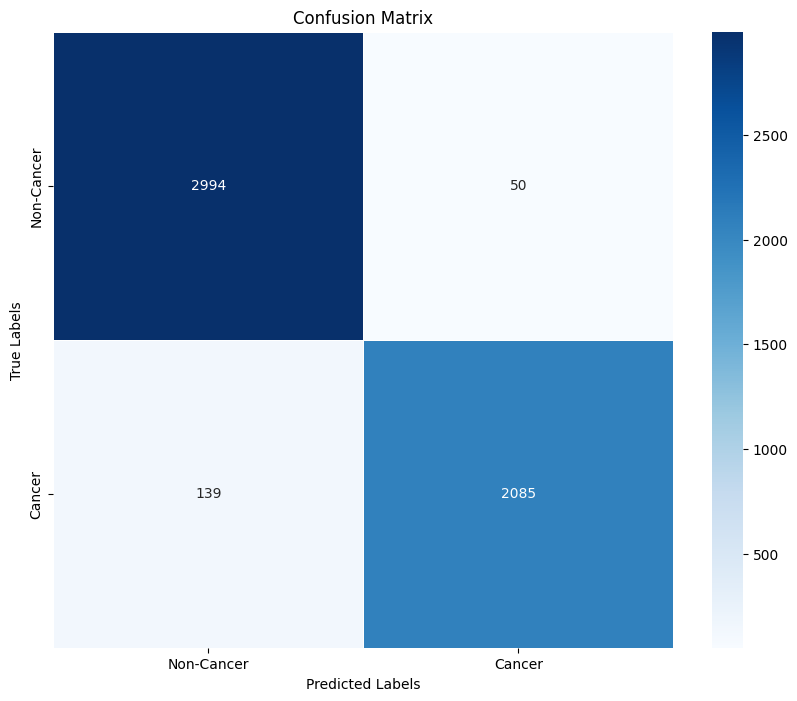

In [62]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Predict using the trained model
Y_pred = model.predict(test_images, steps=len(test_images))
Y_pred_classes = np.argmax(Y_pred , axis=1)

# Extract true labels from the test generator
# This assumes that test_datagen is correctly set up with y_test
Y_true = np.argmax((test_labels), axis=1)  # Modify this if your setup differs

# Calculate the confusion matrix
confusion_mtx = confusion_matrix(Y_true, Y_pred_classes)

# Plot the confusion matrix
plt.figure(figsize=(10, 8))
ax = sns.heatmap(confusion_mtx, annot=True, fmt="d", linewidths=.5, cmap="Blues")
ax.set_xlabel('Predicted Labels')
ax.set_ylabel('True Labels')
ax.set_title('Confusion Matrix')
ax.xaxis.set_ticklabels(['Non-Cancer', 'Cancer'])
ax.yaxis.set_ticklabels(['Non-Cancer', 'Cancer'])
plt.show()


In [63]:
from sklearn.metrics import precision_score, recall_score, f1_score, roc_auc_score, roc_curve
import matplotlib.pyplot as plt

# Assuming Y_pred and Y_true are already defined
# Y_pred is the output from model.predict, Y_pred_classes is obtained by np.argmax(Y_pred, axis=1)
Y_true = np.argmax(test_labels, axis=1)  # Make sure y_test is correctly prepared

# Calculate Precision, Recall, and F1 Score
precision = precision_score(Y_true, Y_pred_classes)
recall = recall_score(Y_true, Y_pred_classes)
f1 = f1_score(Y_true, Y_pred_classes)

# Calculate the probabilities for the positive class
Y_pred_probs = Y_pred[:, 1]  # assuming your model outputs probabilities for each class

# ROC AUC Score
roc_auc = roc_auc_score(Y_true, Y_pred_probs)

# Print the metrics
print(f"Precision: {precision:.2f}")
print(f"Recall: {recall:.2f}")
print(f"F1 Score: {f1:.2f}")
print(f"ROC AUC Score: {roc_auc:.2f}")

Precision: 0.98
Recall: 0.94
F1 Score: 0.96
ROC AUC Score: 1.00


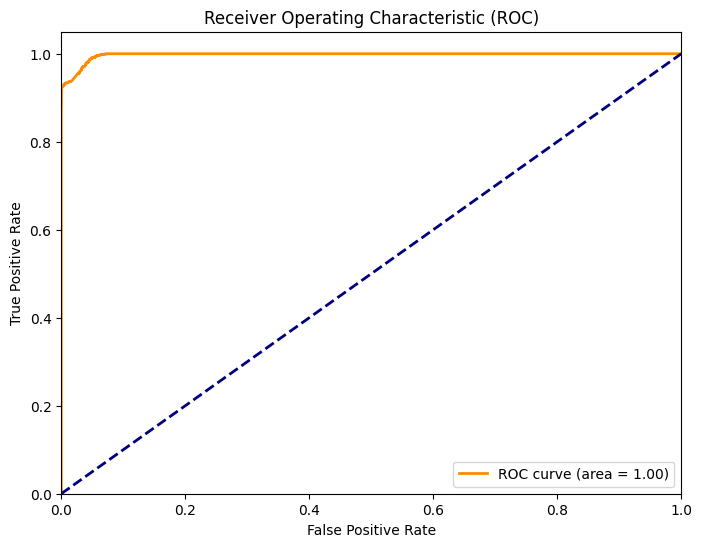

In [64]:
# Plot ROC Curve
fpr, tpr, _ = roc_curve(Y_true, Y_pred_probs)
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC)')
plt.legend(loc="lower right")
plt.show()


In [60]:
model.save('NEWCBS_Update.h5')